# Parameter Sweep for UMAP

The last piece of this puzzle is to generate a visualization to show how a word is shifting through time.
The initial analysis here is to see how the original umap clusters words together and figure out the optimal parameters.
The next notebook will explore parametric umap, which is a hybrid of umap and neural networks to project data into a low dimensional space.

In [1]:
import itertools
from pathlib import Path
import re

from gensim.models import Word2Vec, KeyedVectors
import numpy as np
import pandas as pd
import plotnine as p9
import plydata as ply
import plydata.tidy as ply_tdy
import tqdm
import umap

# Unaligned Models

## Load the paths for each year

The goal here is to grab the odd years unaligned and see if umap can tease apart odd years.

In [2]:
unaligned_word_models = list(
    Path("../multi_model_experiment/output/models").rglob("*model")
)
unaligned_word_models = sorted(unaligned_word_models, key=lambda x: x.stem)
unaligned_word_model_filter = list(
    filter(lambda x: "_0" in x.stem, unaligned_word_models)
)

In [3]:
word_freq_count_cutoff = 5
odd_year_subset = unaligned_word_model_filter[11:-1:2]

In [4]:
training_unaligned_word_model_map = dict()
for word_file in tqdm.tqdm(odd_year_subset):
    model = Word2Vec.load(str(word_file)).wv
    training_unaligned_word_model_map[word_file.stem.split("_")[0]] = dict(
        model=model,
        cutoff_index=min(
            map(
                lambda x: 999999
                if model.get_vecattr(x[1], "count") > word_freq_count_cutoff
                else x[0],
                enumerate(model.index_to_key),
            )
        ),
    )

100%|██████████| 5/5 [01:04<00:00, 12.84s/it]


In [5]:
words_to_visualize = []
token_character_list = []
year_labels_list = []

In [6]:
for year in tqdm.tqdm(training_unaligned_word_model_map):
    model = training_unaligned_word_model_map[year]["model"]
    word_subset_matrix = model[
        model.index_to_key[: training_unaligned_word_model_map[year]["cutoff_index"]]
    ]
    print((year, word_subset_matrix.shape))
    words_to_visualize.append(word_subset_matrix)
    token_character_list += list(
        map(
            lambda x: re.escape(x),
            model.index_to_key[
                : training_unaligned_word_model_map[year]["cutoff_index"]
            ],
        )
    )
    year_labels_list += [year] * len(
        model.index_to_key[: training_unaligned_word_model_map[year]["cutoff_index"]]
    )

 20%|██        | 1/5 [00:00<00:01,  3.47it/s]

('2011', (96901, 300))


 40%|████      | 2/5 [00:00<00:00,  3.25it/s]

('2013', (119889, 300))


 60%|██████    | 3/5 [00:01<00:00,  2.87it/s]

('2015', (147527, 300))


 80%|████████  | 4/5 [00:01<00:00,  2.52it/s]

('2017', (169505, 300))


100%|██████████| 5/5 [00:02<00:00,  2.32it/s]

('2019', (186185, 300))


In [7]:
training_unaligned_words = np.vstack(words_to_visualize)
training_unaligned_words

array([[ 1.8501991 , -0.72549886,  1.0029932 , ...,  0.5002024 ,
         1.2495077 , -0.09042489],
       [ 0.13811398, -3.0941381 ,  1.8036726 , ..., -1.1112565 ,
        -1.8135874 ,  0.5188067 ],
       [-1.1124424 , -2.9671814 ,  1.3655419 , ...,  1.156606  ,
        -0.502162  , -1.0227913 ],
       ...,
       [-0.07918239,  0.18208978,  0.07615598, ...,  0.11903059,
        -0.15270653,  0.19653583],
       [ 0.01853782, -0.17419356,  0.10265009, ...,  0.04317793,
         0.00603391,  0.00340904],
       [-0.06166358, -0.08175758, -0.1584587 , ..., -0.10701022,
         0.13988794,  0.17704478]], dtype=float32)

## Run the Parameter Sweep

In [8]:
n_neighbors = [10, 25, 50, 75]
epoch_multiplier = [1]
param_output = []

In [9]:
for neighbors, epoch_m in itertools.product(n_neighbors, epoch_multiplier):
    file_name = f"output/umap_parameter_sweep/unaligned/neighbors({neighbors})_epochs({epoch_m})"

    if Path(f"{file_name}.tsv").exists():
        continue

    print(neighbors, epoch_m)

    model = umap.UMAP(
        verbose=True,
        metric="cosine",
        random_state=101,
        low_memory=True,
        n_neighbors=neighbors,
        min_dist=0.99,
        n_epochs=epoch_m * 10,
    )

    umap_embeddings = model.fit_transform(training_unaligned_words)

    (
        pd.DataFrame(umap_embeddings, columns=["umap1", "umap2"])
        >> ply.define(year=year_labels_list, tok=token_character_list)
        >> ply.define(neighbors=neighbors, epochs=epoch_m)
        >> ply.call(
            ".to_csv",
            f"output/umap_parameter_sweep/unaligned/neighbors({neighbors})_epochs({epoch_m}).tsv",
            sep="\t",
            index=False,
        )
    )

## Visualize Embeddings

Now that we have generated each embedding its time to visually confirm the years can be separated.

In [10]:
plot_df = pd.concat(
    [
        pd.read_csv(str(file), sep="\t")
        >> ply.call(".dropna")
        >> ply.define(umap1="umap1.astype(float)")
        for file in Path("output/umap_parameter_sweep/unaligned").rglob("*tsv")
    ]
)
plot_df >> ply.slice_rows(20)

/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3347: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3347: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3347: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3347: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.


,umap1,umap2,year,tok,neighbors,epochs
0,6.353494,4.630541,2011,\,10.0,1.0
1,8.885780,6.523138,2011,the,10.0,1.0
2,10.634675,6.715146,2011,",",10.0,1.0
3,5.903692,7.470763,2011,of,10.0,1.0
4,5.758046,5.412948,2011,\.,10.0,1.0
5,8.817812,4.759219,2011,and,10.0,1.0
6,7.390529,5.507077,2011,in,10.0,1.0
7,7.686014,4.442650,2011,\-,10.0,1.0
8,7.954956,7.638203,2011,to,10.0,1.0
9,8.213235,7.305350,2011,a,10.0,1.0


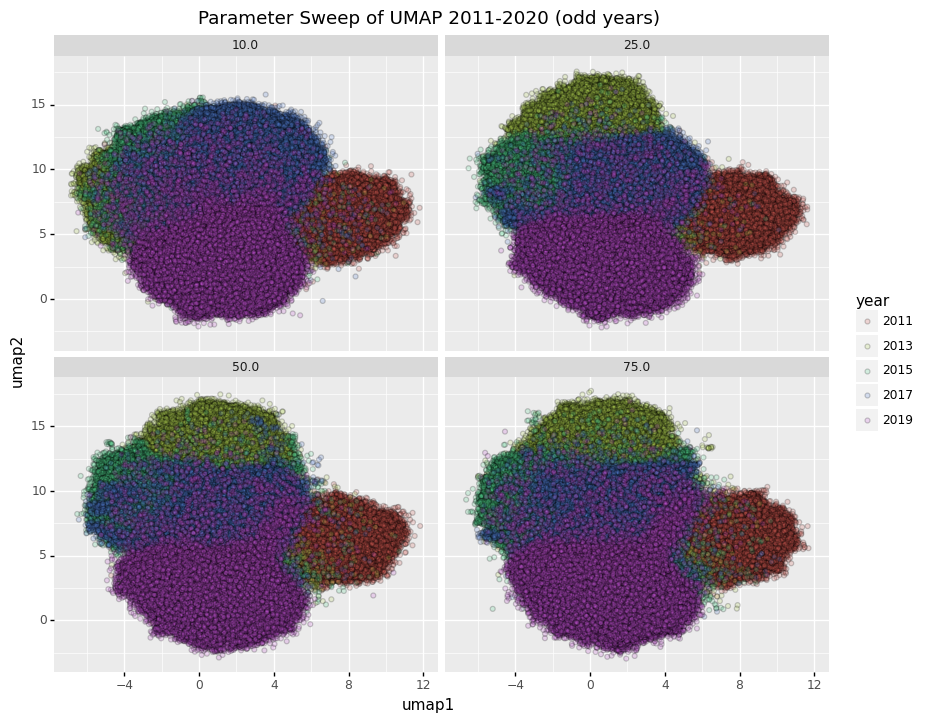

In [11]:
g = (
    p9.ggplot(
        plot_df >> ply.define(year="pd.Categorical(year)"),
        p9.aes(x="umap1", y="umap2", fill="year"),
    )
    + p9.geom_point(alpha=0.2)
    + p9.labs(title="Parameter Sweep of UMAP 2011-2020 (odd years)")
    + p9.theme(figure_size=(10, 8))
    + p9.facet_wrap("neighbors")
)
print(g)

# Aligned Models

## Load the paths for each year

The goal here is to grab the odd years unaligned and see if umap can tease apart odd years.

In [12]:
aligned_word_models = list(
    Path("../multi_model_experiment/output/aligned_vectors_tmp").rglob("*kv")
)
aligned_word_models = sorted(aligned_word_models, key=lambda x: x.stem)
aligned_word_model_filter = list(filter(lambda x: "_0" in x.stem, aligned_word_models))

In [13]:
word_freq_count_cutoff = 1
odd_year_subset = aligned_word_model_filter[11:-1:2]

In [14]:
aligned_training_word_model_map = dict()
for word_file in tqdm.tqdm(odd_year_subset):
    model = KeyedVectors.load(str(word_file))
    aligned_training_word_model_map[word_file.stem.split("_")[0]] = dict(
        model=model,
        cutoff_index=min(
            map(
                lambda x: 999999
                if model.get_vecattr(x[1], "count") > word_freq_count_cutoff
                else x[0],
                enumerate(model.index_to_key),
            )
        ),
    )

100%|██████████| 5/5 [00:14<00:00,  2.95s/it]


In [15]:
words_to_visualize = []
token_character_list = []
year_labels_list = []

In [16]:
for year in tqdm.tqdm(aligned_training_word_model_map):
    model = aligned_training_word_model_map[year]["model"]
    word_subset_matrix = model[model.index_to_key]
    print((year, word_subset_matrix.shape))
    words_to_visualize.append(word_subset_matrix)
    token_character_list += list(map(lambda x: re.escape(x), model.index_to_key))
    year_labels_list += [year] * len(model.index_to_key)

 20%|██        | 1/5 [00:00<00:01,  2.08it/s]

('2011', (184237, 300))


 40%|████      | 2/5 [00:01<00:01,  1.98it/s]

('2013', (214460, 300))


 60%|██████    | 3/5 [00:01<00:01,  1.84it/s]

('2015', (243168, 300))


 80%|████████  | 4/5 [00:02<00:00,  1.70it/s]

('2017', (264969, 300))


100%|██████████| 5/5 [00:03<00:00,  1.61it/s]

('2019', (285138, 300))


In [17]:
aligned_training_words = np.vstack(words_to_visualize)
aligned_training_words.shape

(1191972, 300)

## Run the Parameter Sweep

In [18]:
n_neighbors = [50]
epoch_multiplier = [1]
param_output = []

In [19]:
for neighbors, epoch_m in itertools.product(n_neighbors, epoch_multiplier):
    file_name = (
        f"output/umap_parameter_sweep/aligned/neighbors({neighbors})_epochs({epoch_m})"
    )

    if Path(f"{file_name}.tsv").exists():
        continue

    print(neighbors, epoch_m)

    model = umap.UMAP(
        verbose=True,
        metric="cosine",
        random_state=101,
        low_memory=True,
        n_neighbors=neighbors,
        min_dist=0.99,
        n_epochs=epoch_m * 10,
    )

    umap_embeddings = model.fit_transform(aligned_training_words)

    (
        pd.DataFrame(umap_embeddings, columns=["umap1", "umap2"])
        >> ply.define(year=year_labels_list, tok=token_character_list)
        >> ply.define(neighbors=neighbors, epochs=epoch_m)
        >> ply.call(
            ".to_csv",
            f"output/umap_parameter_sweep/aligned/neighbors({neighbors})_epochs({epoch_m}).tsv",
            sep="\t",
            index=False,
        )
    )

## Visualize Embeddings

Now that we have generated each embedding its time to visually confirm the years can be separated.

In [20]:
plot_df = pd.concat(
    [
        pd.read_csv(str(file), sep="\t")
        >> ply.call(".dropna")
        >> ply.define(umap1="umap1.astype(float)")
        for file in Path("output/umap_parameter_sweep/aligned").rglob("*tsv")
    ]
)
plot_df >> ply.slice_rows(20)

,umap1,umap2,year,tok,neighbors,epochs
0,8.777575,4.667029,2011,\,50,1
1,4.510737,7.362120,2011,the,50,1
2,4.749421,6.882555,2011,",",50,1
3,4.255577,6.977624,2011,\.,50,1
4,8.960563,11.537645,2011,of,50,1
5,4.437625,6.499268,2011,and,50,1
6,17.256403,1.613814,2011,in,50,1
7,1.328183,2.859775,2011,\-,50,1
8,6.626180,7.501995,2011,to,50,1
9,4.513312,4.379673,2011,\),50,1


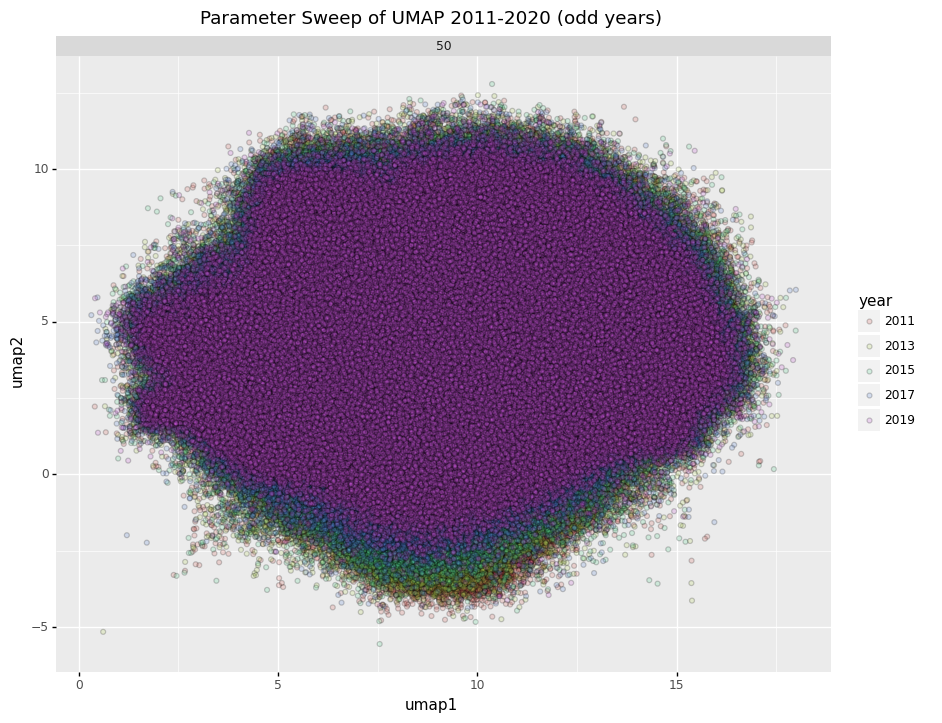

In [21]:
g = (
    p9.ggplot(
        plot_df >> ply.define(year="pd.Categorical(year)"),
        p9.aes(x="umap1", y="umap2", fill="year"),
    )
    + p9.geom_point(alpha=0.2)
    + p9.labs(title="Parameter Sweep of UMAP 2011-2020 (odd years)")
    + p9.theme(figure_size=(10, 8))
    + p9.facet_wrap("neighbors")
)
print(g)

# Take Home Messages

1. UMAP is able to capture different clusters across the odd years.
2. The more neighbors one uses for the umap algorithm the more distinct the clusters for unaligned word vector models.
3. After alignment it does appear that orthogonal procustes is able to fix this issue by allowing words from the different years be placed closer together.
4. Moving forward onto the next experiment, I'll be using neighbor values of at least 20.